In [16]:
# LOAD Packages 
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import os
import math
import csv
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [17]:
# open file
tracks = uproot.open("/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/track_reco_benchmark.root")
tracks["RecoBenchmarkTree"].show()
tracks["RecoBenchmarkTree"].keys()
tracks["RecoBenchmarkTree"][0].num_entries

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_track_start_x   | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_track_start_y   | std::

1

In [51]:
# Set up data frame
df = tracks["RecoBenchmarkTree"].arrays(library="pd")
ovlp_cut = 0.5
df_filtered = df[df['overlap']>=ovlp_cut]
print(df_filtered.index[0])
track_number = 3412

reco_ixn_idx = df_filtered[df_filtered.index==(0,track_number)]['reco_ixn_index'].values[0]
true_ixn_idx = df_filtered[df_filtered.index==(0,track_number)]['true_ixn_index'].values[0]
spill_idx = df_filtered[df_filtered.index==(0,track_number)]['spill_index'].values[0]
file_idx = df_filtered[df_filtered.index==(0,track_number)]['file_index'].values[0]
print("Reco interaction index:", reco_ixn_idx)
print("True interaction index:", true_ixn_idx)
print("Spill index:", spill_idx)
print("File index:", file_idx)


(0, 0)
Reco interaction index: 1.0
True interaction index: 0.0
Spill index: 12
File index: 29


In [52]:
# Get points of reco and true track start and end to plot
df_tracks_file = df_filtered[df_filtered['file_index']==file_idx]
df_tracks_spill = df_tracks_file[df_tracks_file['spill_index']==spill_idx]
df_reco_tracks = df_tracks_spill[df_tracks_spill['reco_ixn_index']==reco_ixn_idx]
df_true_tracks = df_tracks_spill[df_tracks_spill['true_ixn_index']==true_ixn_idx]

print(len(df_reco_tracks))
print(len(df_true_tracks))

reco_start_x_all, reco_end_x_all = np.zeros(len(df_reco_tracks)), np.zeros(len(df_reco_tracks))
reco_start_y_all, reco_end_y_all = np.zeros(len(df_reco_tracks)), np.zeros(len(df_reco_tracks))
reco_start_z_all, reco_end_z_all = np.zeros(len(df_reco_tracks)), np.zeros(len(df_reco_tracks))
true_start_x_all, true_end_x_all = np.zeros(len(df_true_tracks)), np.zeros(len(df_true_tracks))
true_start_y_all, true_end_y_all = np.zeros(len(df_true_tracks)), np.zeros(len(df_true_tracks))
true_start_z_all, true_end_z_all = np.zeros(len(df_true_tracks)), np.zeros(len(df_true_tracks))

for i in range(len(df_reco_tracks)):

    reco_start_x_all[i] = df_reco_tracks['reco_track_start_x'].values[i]
    reco_start_y_all[i] = df_reco_tracks['reco_track_start_y'].values[i]
    reco_start_z_all[i] = df_reco_tracks['reco_track_start_z'].values[i]
    reco_end_x_all[i] = df_reco_tracks['reco_track_end_x'].values[i]
    reco_end_y_all[i] = df_reco_tracks['reco_track_end_y'].values[i]
    reco_end_z_all[i] = df_reco_tracks['reco_track_end_z'].values[i]

for i in range(len(df_true_tracks)):

    true_start_x_all[i] = df_true_tracks['true_track_start_x'].values[i]
    true_start_y_all[i] = df_true_tracks['true_track_start_y'].values[i]
    true_start_z_all[i] = df_true_tracks['true_track_start_z'].values[i]
    true_end_x_all[i] = df_true_tracks['true_track_end_x'].values[i]
    true_end_y_all[i] = df_true_tracks['true_track_end_y'].values[i]
    true_end_z_all[i] = df_true_tracks['true_track_end_z'].values[i]

alphas = [0.9, 0.8, 0.7, 0.6, 0.5]
print(df_reco_tracks['reco_track_start_x'].values)
print(reco_end_x_all)
print(true_start_x_all)
print(true_end_x_all)

    

2
3
[57.86370087 60.08069992]
[59.63729858 59.19390106]
[60.64049911 60.16156387 60.76822281]
[34.70888519 56.90480423 32.81433487]


0
1


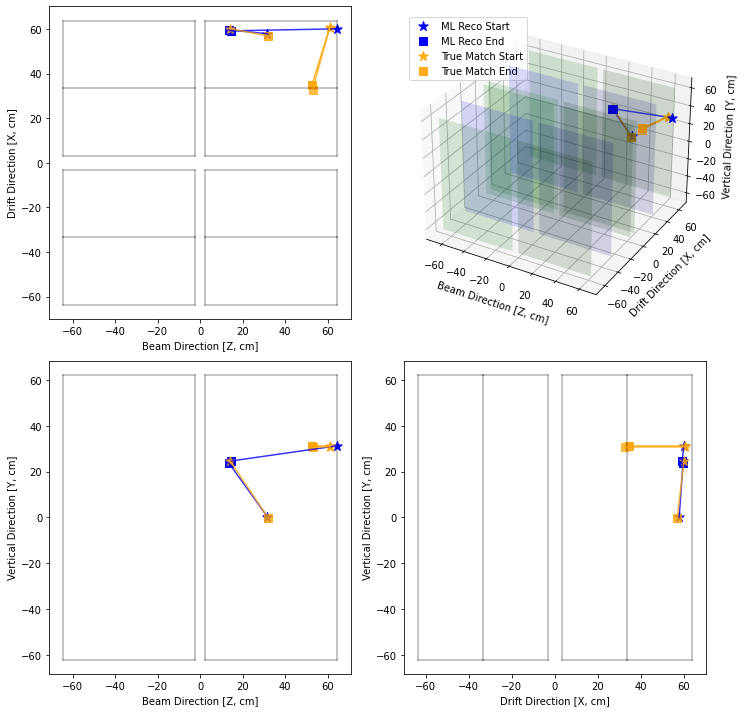

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(222, projection='3d')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

def make_cathode_or_anode(y1, y2, z1, z2, x):
    y = np.linspace(y1, y2, 100)
    z = np.linspace(z1, z2, 100)
    Y, Z = np.meshgrid(y, z)
    X = np.full(Y.shape, x)
    return X, Y, Z

# Plot TPC Surfaces
anode_y1s = [-62.076, -62.076, -62.076, -62.076, -62.076, -62.076, -62.076, -62.076]
anode_y2s = [62.076, 62.076, 62.076, 62.076, 62.076, 62.076, 62.076,62.076]
anode_z1s = [2.462, 2.462, 2.462, 2.462, -2.462, -2.462, -2.462, -2.462]
anode_z2s = [2.462+62.076, 2.462+62.076, 2.462+62.076, 2.462+62.076, -2.462-62.076, -2.462-62.076, -2.462-62.076, -2.462-62.076]
anode_xs = [33.5+30.27225, -33.5+30.27225, 33.5-30.27225, -33.5-30.27225, 33.5+30.27225, -33.5+30.27225, 33.5-30.27225, -33.5-30.27225]

cathode_y1s = [-62.076, -62.076, -62.076, -62.076]
cathode_y2s = [62.076, 62.076, 62.076, 62.076]
cathode_z1s = [2.462, 2.462, -2.462, -2.462]
cathode_z2s = [2.462+62.076, 2.462+62.076, -2.462-62.076, -2.462-62.076]
cathode_xs = [33.5, -33.5, 33.5, -33.5]


for i in range(len(cathode_y1s)):
    X_cathode, Y_cathode, Z_cathode = make_cathode_or_anode(cathode_y1s[i], cathode_y2s[i], cathode_z1s[i], cathode_z2s[i], cathode_xs[i])
    ax.plot_surface(Z_cathode,X_cathode,Y_cathode, color='b', alpha=0.15)
for i in range(len(anode_y1s)):
    X_anode, Y_anode, Z_anode = make_cathode_or_anode(anode_y1s[i], anode_y2s[i], anode_z1s[i], anode_z2s[i], anode_xs[i])
    ax.plot_surface(Z_anode,X_anode,Y_anode, color='g', alpha=0.15)

ax.set_xlabel('Beam Direction [Z, cm]')
ax.set_ylabel('Drift Direction [X, cm]')
ax.set_zlabel('Vertical Direction [Y, cm]')

# Plot outlines of detector for projections:
ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[0], anode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[2], anode_xs[2]], color='k', alpha=0.3)
#ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[1], anode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[3], anode_xs[3]], color='k', alpha=0.3)
#ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[0], anode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[2], anode_xs[2]], color='k', alpha=0.3)
#ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[1], anode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[3], anode_xs[3]], color='k', alpha=0.3)
#ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

ax1.set_xlabel('Beam Direction [Z, cm]')
ax1.set_ylabel('Drift Direction [X, cm]')

ax2.plot([anode_z1s[-1], anode_z1s[-1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax2.plot([anode_z1s[0], anode_z1s[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax2.plot([anode_z2s[-1], anode_z2s[-1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax2.plot([anode_z2s[0], anode_z2s[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax2.plot([anode_z1s[-1], anode_z2s[-1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
ax2.plot([anode_z1s[0], anode_z2s[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
ax2.plot([anode_z1s[-1], anode_z2s[-1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
ax2.plot([anode_z1s[0], anode_z2s[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)

ax2.set_xlabel('Beam Direction [Z, cm]')
ax2.set_ylabel('Vertical Direction [Y, cm]')


ax3.plot([anode_xs[0], cathode_xs[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[1], cathode_xs[1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[2], cathode_xs[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[3], cathode_xs[1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[2], cathode_xs[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[3], cathode_xs[1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[0], cathode_xs[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[1], cathode_xs[1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[0], anode_xs[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[1], anode_xs[1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[2], anode_xs[2]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([anode_xs[3], anode_xs[3]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([cathode_xs[0], cathode_xs[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
ax3.plot([cathode_xs[1], cathode_xs[1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)

ax3.set_xlabel('Drift Direction [X, cm]')
ax3.set_ylabel('Vertical Direction [Y, cm]')


for i in range(len(df_reco_tracks)):
    print(i)
    reco_start_x, reco_end_x = reco_start_x_all[i], reco_end_x_all[i]
    reco_start_y, reco_end_y = reco_start_y_all[i], reco_end_y_all[i]
    reco_start_z, reco_end_z = reco_start_z_all[i], reco_end_z_all[i]

    ax.plot([reco_start_z, reco_end_z], [reco_start_x, reco_end_x], [reco_start_y, reco_end_y], \
              color='b', alpha=0.7)
    if i==0:
        ax.scatter(reco_start_z, reco_start_x, reco_start_y, color='b', marker='*', s=100, label='ML Reco Start')
        ax.scatter(reco_end_z, reco_end_x, reco_end_y, color='b', marker='s', s=50, label='ML Reco End')
    else:
        ax.scatter(reco_start_z, reco_start_x, reco_start_y, color='b', marker='*', s=100)
        ax.scatter(reco_end_z, reco_end_x, reco_end_y, color='b', marker='s', s=50)

    ax1.plot([reco_start_z, reco_end_z], [reco_start_x, reco_end_x], alpha=0.8,  color='b')
    ax1.scatter(reco_start_z, reco_start_x, color='b', marker='*', s=100)
    ax1.scatter(reco_end_z, reco_end_x, color='b', marker='s', s=50)

    ax2.plot([reco_start_z, reco_end_z], [reco_start_y, reco_end_y], alpha=0.8,color='b')
    ax2.scatter(reco_start_z, reco_start_y, color='b', marker='*', s=100)
    ax2.scatter(reco_end_z, reco_end_y, color='b', marker='s', s=50 )

    ax3.plot([reco_start_x, reco_end_x], [reco_start_y, reco_end_y], alpha=0.8, color='b')
    ax3.scatter(reco_start_x, reco_start_y, color='b', marker='*', s=100)
    ax3.scatter(reco_end_x, reco_end_y, color='b', marker='s', s=50)

for i in range(len(df_true_tracks)):

    true_start_x, true_end_x = true_start_x_all[i], true_end_x_all[i]
    true_start_y, true_end_y = true_start_y_all[i], true_end_y_all[i]
    true_start_z, true_end_z = true_start_z_all[i], true_end_z_all[i]

    ax.plot([true_start_z, true_end_z], [true_start_x, true_end_x], [true_start_y, true_end_y], \
             color='orange', alpha=alphas[i])
    if i==0:
        ax.scatter(true_start_z, true_start_x, true_start_y, color='orange', marker='*', s=100, alpha=alphas[i], label='True Match Start')
        ax.scatter(true_end_z, true_end_x, true_end_y, color='orange', marker='s', s=50, alpha=alphas[i], label='True Match End')
    else:
        ax.scatter(true_start_z, true_start_x, true_start_y, color='orange', alpha=alphas[i], marker='*', s=100)
        ax.scatter(true_end_z, true_end_x, true_end_y, color='orange', alpha=alphas[i],marker='s', s=50)
    ax1.plot([true_start_z, true_end_z], [true_start_x, true_end_x], alpha=alphas[i], color='orange')
    ax1.scatter(true_start_z, true_start_x, color='orange', marker='*', s=100,alpha=alphas[i])
    ax1.scatter(true_end_z, true_end_x, color='orange', marker='s', s=50,alpha=alphas[i])

    ax2.plot([true_start_z, true_end_z], [true_start_y, true_end_y], alpha=alphas[i],  color='orange')
    ax2.scatter(true_start_z, true_start_y, color='orange', marker='*', s=100,alpha=alphas[i])
    ax2.scatter(true_end_z, true_end_y, color='orange', marker='s', s=50,alpha=alphas[i])

    ax3.plot([true_start_x, true_end_x], [true_start_y, true_end_y], alpha=alphas[i], color='orange')
    ax3.scatter(true_start_x, true_start_y, color='orange', marker='*', alpha=alphas[i], s=100)
    ax3.scatter(true_end_x, true_end_y, color='orange', marker='s', alpha=alphas[i], s=50)

ax.legend(loc='upper left')
plt.tight_layout()
#plt.show()
plt.savefig('/exp/dune/app/users/ehinkle/nd_analysis/2x2_CAFs/reco_studies/track_'+str(track_number)+'_true_vs_reco_abs_cos_rot_angle_difference_with_ovlp_cut_'+str(ovlp_cut)+'.png')
